# SEQNET

In [1]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Import custom library to DR
from dr_filters.channels import chanel
from dr_filters.clahe import clahe, clahe_custom

## Load config SeqNet to take outtput folder

In [2]:
import json

with open("config.json") as json_config_file:
    config_file = json.load(json_config_file)

## Define raw folder to run seqnet and output final image to combinate then the process finish

In [3]:
folder_raw = "./raw_images"
folder_masks = f"{config_file['seqnet']['output']}/out_seg/"

In [4]:
from dr_filters.seqnet import seqnet_predict

# This function will create four folders with the resoults 
seqnet_predict.predict(input_path=folder_raw)

Instructions for updating:
non-resource variables are not supported in the long term
[*]output path: ./output/seqnet
Model : .\models\seqnet\Final_Emer_Iteration_3_cropsize_128_epochs_200.hdf5


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\leona\miniconda3\envs\seqnet\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
100%|██████████| 1/1 [06:40<00:00, 400.63s/it]


In [6]:
def read_images_folder(path_folder=None):
    print(f"Input folder: {path_folder}")
    exts_list = ['png', 'jpg', 'tif', 'bmp', 'gif', 'jpeg']
    path_image_list = []
    
    if path_folder:
        for each_file in os.listdir(path_folder):
            for exts in exts_list:
                if each_file.endswith(exts):
                    path_img = os.path.join(folder_raw, each_file)
                    
                    img_info = {
                        "path" : path_img,
                        "name" : each_file[:each_file.rfind('.')],
                        "extension": exts
                    }
                    path_image_list.append(img_info)
                    
                    break
    
    return path_image_list
    
    

In [7]:
list_path_raw_images = read_images_folder(folder_raw)
list_path_mask_images = read_images_folder(folder_masks)

Input folder: ./raw_images
Input folder: ./output/seqnet/out_seg/


## Process to combinate image and mask

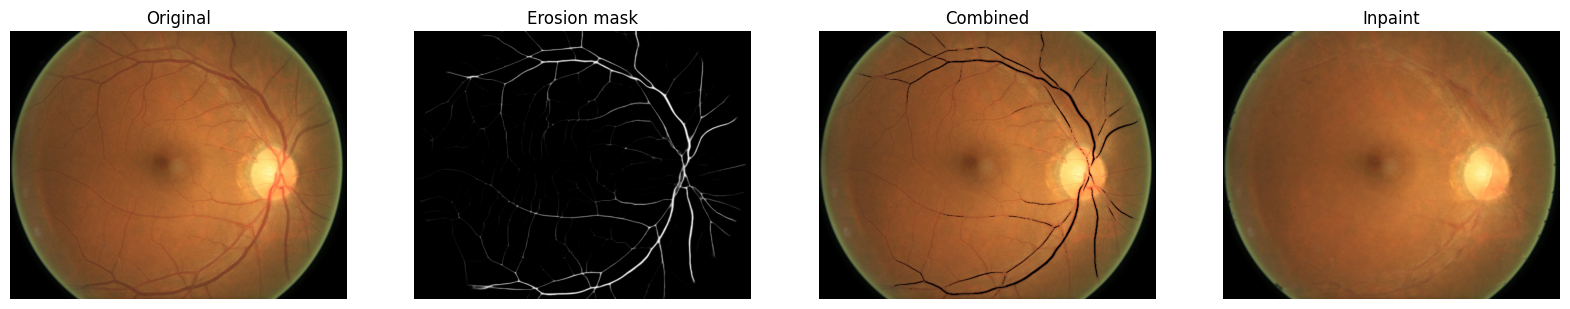

In [9]:
for img in list_path_raw_images:
    if img["name"] in [ img_mask["name"] for img_mask in list_path_mask_images]:
        
        img_mask_ext = [img_mask["extension"] for img_mask in list_path_mask_images]
        
        
        
        raw_img_path = f"{folder_raw}/{img['name']}.{img['extension']}"
        mask_img_path = f"{folder_masks}/{img['name']}.{img_mask_ext[0]}"
               
        raw_img_src = cv2.imread(raw_img_path)
        mask_img_src = cv2.imread(mask_img_path)
        
        raw_img = cv2.cvtColor(raw_img_src, cv2.COLOR_BGR2RGB)
        mask_img = cv2.cvtColor(mask_img_src, cv2.COLOR_BGR2RGB)
    
        kernel = np.ones((5,5),np.uint8)
        erosion = cv2.erode(mask_img,kernel,iterations = 1)
        
        
    
        img_preprocesada = np.uint8(mask_img)
        _, binarized = cv2.threshold(img_preprocesada, 250, 255, cv2.THRESH_BINARY)
        inverted = cv2.bitwise_not(binarized)
        mask = np.zeros_like(raw_img)
        mask[inverted == 255] = 255
        img_final = cv2.bitwise_and(raw_img, mask)
        mask_gray = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
        impaint_result = cv2.inpaint(img_final,mask_gray,3,cv2.INPAINT_TELEA)

        
        # ===== PRINT PROCESS AND RESULTS =====
        
        fig = plt.figure(figsize=(20, 40))
        ax1 = fig.add_subplot(4, 4, 1)
        ax1.axis("off")
        ax1.title.set_text('Original')

        ax2 = fig.add_subplot(4, 4, 2)
        ax2.axis("off")
        ax2.title.set_text("Erosion mask")

        ax3 = fig.add_subplot(4, 4, 3)
        ax3.axis("off")
        ax3.title.set_text("Combined")

        ax4 = fig.add_subplot(4, 4, 4)
        ax4.axis("off")
        ax4.title.set_text("Inpaint")

        ax1.imshow(raw_img, cmap=None)
        ax2.imshow(erosion, cmap=None)
        ax3.imshow(img_final, cmap=None)
        ax4.imshow(impaint_result, cmap=None)
        
        
        # Save images
        
        output_path = config_file["seqnet"]["output"]
        os.makedirs(f"{output_path}/combinate_masks/", exist_ok=True)
        cv2.imwrite(f"{output_path}/combinate_masks/{img['name']}.png", cv2.cvtColor(img_final, cv2.COLOR_RGB2BGR))
        
        os.makedirs(f"{output_path}/impaint/", exist_ok=True)
        cv2.imwrite(f"{output_path}/impaint/{img['name']}.png", cv2.cvtColor(impaint_result, cv2.COLOR_RGB2BGR))   